In [70]:
import simpy
from mylibrary import MonitoredResource
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snd
snd.set(rc={'figure.figsize':(15,8.27)})
cashierWaitTime = []
stationWaitTime = []
cashierUsersY = []
cashierUsersX = []
stationUsersY = []
stationUsersX = []
stationUtilizationX = []
stationUtilizationY = []
cashierUtilizationX = []
cashierUtilizationY = []
stationBusyPeriod = []
cashierBusyPeriod = []
percievedWaitTime = []
log = []
plt.figure(num=None, figsize=(20, 20))
SIMULATIONTIME = 600
CASHIERSERVICERATE = 2.142
STATIONSERVICERATE = 2.109
ARRIVALRATE =  3.342
ORDERRATE = 0.5
PAYMENTRATE = 2.142-0.5
RANDOM_SEED = 37
np.random.seed(RANDOM_SEED)

<Figure size 1440x1440 with 0 Axes>

In [71]:
class Cafe:
    def __init__(self, env):
        self.cashier = MonitoredResource(env, capacity=1)
        self.station = MonitoredResource(env, capacity=1)

In [72]:
def Order(name, env, cafe, serviceRate):
    print('Order %s is heard at %s' % (name, env.now))
    order_name = 'Order ' + str(name)
    log.append({'Time': env.now, 'Entity': order_name, 'Event': 'Enters'})
    tempWaitTime = env.now
    serviceTime = np.random.exponential(serviceRate)
    stationUsersY.append( len(cafe.station.users))
    stationUsersX.append(env.now)
    with cafe.station.request() as req:
        yield req
        tempBusyTime = env.now
        stationUtilizationX.append(env.now)
        stationUtilizationY.append(1)
        stationWaitTime.append(env.now - tempWaitTime)
        print('Staff starts to make the order %s at %s' % (name, env.now))
        log.append({'Time': env.now, 'Entity': order_name, 'Event': 'Processing'})
        yield env.timeout(serviceTime)
        print('Stafff finish making order %s  at %s' % (name, env.now))
        stationBusyPeriod.append(env.now-tempBusyTime)
        stationUsersY.append(len(cafe.station.queue) + len(cafe.station.users))
        stationUsersX.append(env.now)
        if env.now-percievedWaitTime[name] < 0:
            percievedWaitTime[name] = 0
        else:
            percievedWaitTime[name] = env.now - percievedWaitTime[name]
        log.append({'Time': env.now, 'Entity': order_name, 'Event': 'Leaves'})
        if len(cafe.station.queue) == 0:
            stationUtilizationX.append(env.now)
            stationUtilizationY.append(0)

In [73]:
def Customer(name, env, cafe, orderRate, paymentRate, stationServiceRate):
    customer_name = 'Customer ' + str(name)
    print('Customer %s arriving at %s' % (name, env.now))
    log.append({'Time': env.now, 'Entity': customer_name, 'Event': 'Enters'})
    tempWaitTime = env.now
    percievedWaitTime.append(env.now)
    cashierUsersY.append(len(cafe.cashier.users))
    cashierUsersX.append(env.now)
    orderTime = np.random.exponential(2.142)
    paymentTime = np.random.exponential(paymentRate)
    with cafe.cashier.request() as req:
        yield req
        tempBusyTime = env.now
        cashierUtilizationX.append(env.now)
        cashierUtilizationY.append(1)
        cashierWaitTime.append(env.now - tempWaitTime)
        print('Customer %s starts to order at %s' % (name, env.now))
        log.append({'Time': env.now, 'Entity': customer_name, 'Event': 'Processing'})
        yield env.timeout(0.3*orderTime)
        env.process(Order(name, env, cafe, stationServiceRate))
        yield env.timeout(0.7*paymentTime)
        print('Customer %s done with ordering at %s' % (name, env.now))
        log.append({'Time': env.now, 'Entity': customer_name, 'Event': 'Leaves'})
        cashierUsersY.append(len(cafe.cashier.queue) + len(cafe.cashier.users))
        cashierUsersX.append(env.now)
        cashierBusyPeriod.append(env.now-tempBusyTime)
        if len(cafe.cashier.queue) == 0:
            cashierUtilizationX.append(env.now)
            cashierUtilizationY.append(0)

In [74]:
def CustomerGenerator(env, cafe, arrivalRate, orderRate, paymentRate, stationServiceRate):
    i = 0
    while env.now < SIMULATIONTIME:
        interArrivalTime = np.random.exponential(arrivalRate)
        env.process(Customer(i, env, cafe, orderRate, paymentRate, stationServiceRate))
        i += 1
        yield env.timeout(interArrivalTime)

In [75]:
env = simpy.Environment()
coffee_world = Cafe(env)
customer_gen = env.process(CustomerGenerator(env, coffee_world, ARRIVALRATE, ORDERRATE, PAYMENTRATE, STATIONSERVICERATE))
env.run(SIMULATIONTIME)


Customer 0 arriving at 0
Customer 0 starts to order at 0
Order 0 is heard at 0.4008566404187787
Staff starts to make the order 0 at 0.4008566404187787
Customer 0 done with ordering at 0.6470324331489121
Stafff finish making order 0  at 2.239951855357112
Customer 1 arriving at 9.662761530185266
Customer 1 starts to order at 9.662761530185266
Order 1 is heard at 10.403500836993928
Staff starts to make the order 1 at 10.403500836993928
Customer 1 done with ordering at 10.529000758893726
Customer 2 arriving at 12.897168034341789
Customer 2 starts to order at 12.897168034341789
Stafff finish making order 1  at 13.289370445974455
Order 2 is heard at 13.796864196156411
Staff starts to make the order 2 at 13.796864196156411
Customer 3 arriving at 14.004227458009975
Customer 2 done with ordering at 15.605577755933814
Customer 3 starts to order at 15.605577755933814
Stafff finish making order 2  at 15.87897744333281
Customer 4 arriving at 15.96286691903734
Customer 5 arriving at 16.6952891745739

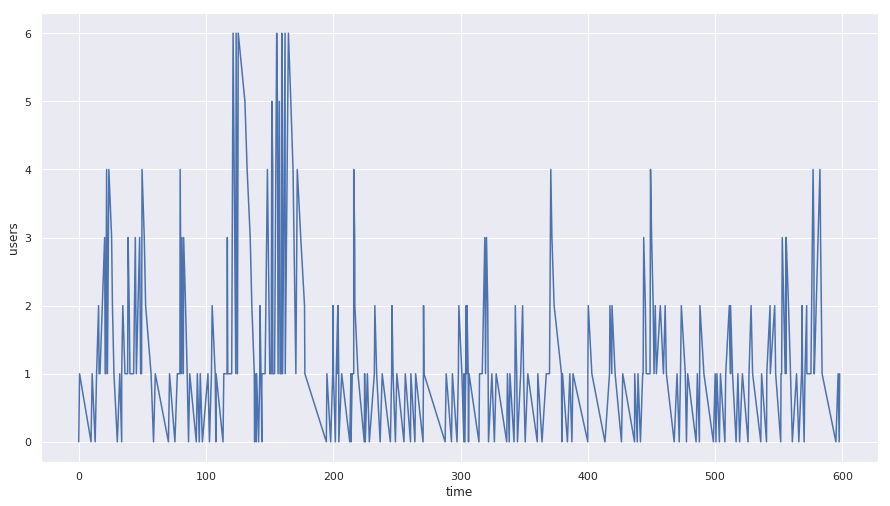

In [76]:
df = pd.DataFrame()
df['time'] = cashierUsersX
df['users'] = cashierUsersY
ax = snd.lineplot(x="time", y="users", data=df)

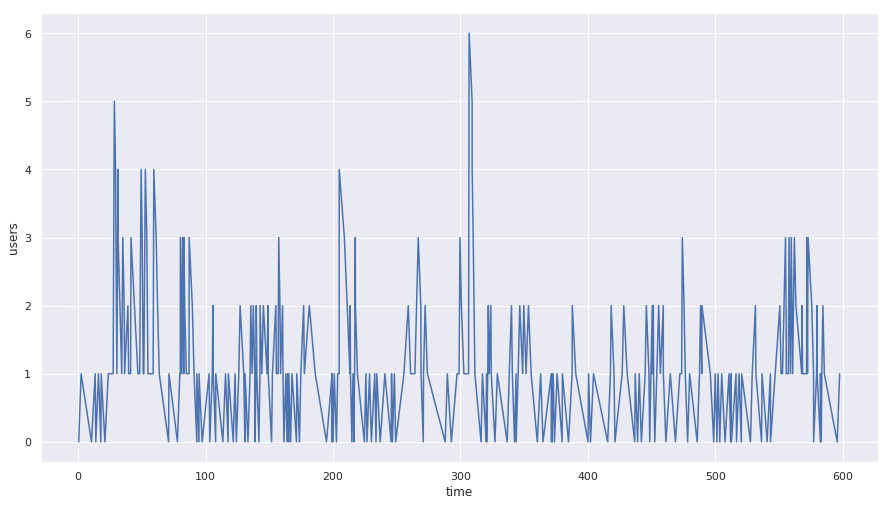

In [77]:
df = pd.DataFrame()
df['time'] = stationUsersX
df['users'] = stationUsersY
ax = snd.lineplot(x="time", y="users", data=df)

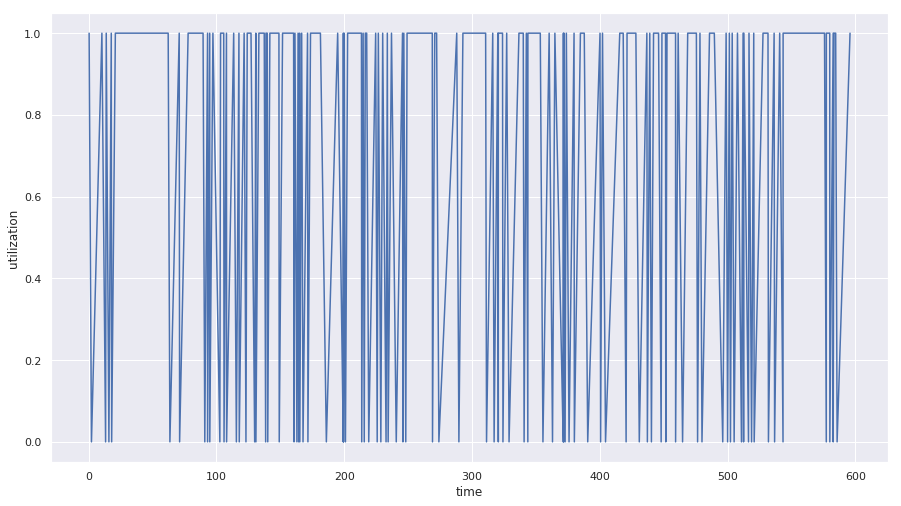

In [78]:
df = pd.DataFrame()
df['time'] = stationUtilizationX
df['utilization'] = stationUtilizationY
ax = snd.lineplot(x="time", y="utilization", data=df)

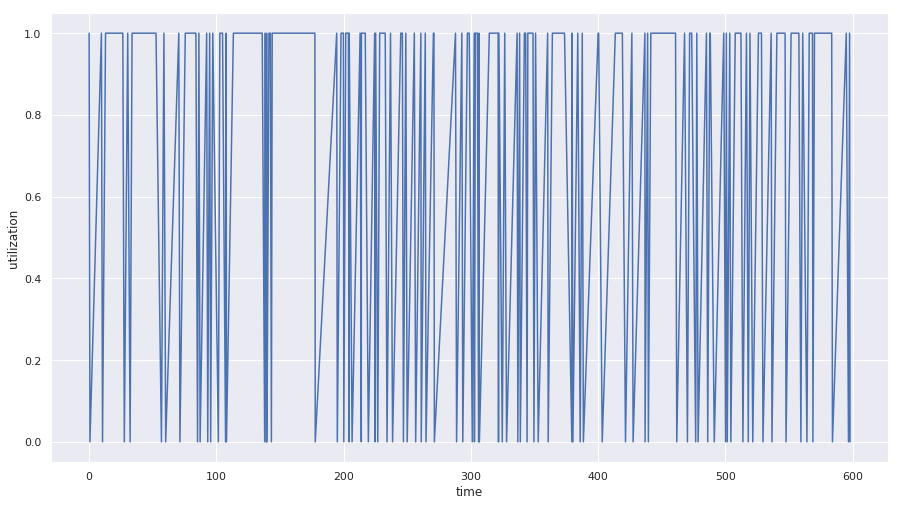

In [79]:
df = pd.DataFrame()
df['time'] = cashierUtilizationX
df['utilization'] = cashierUtilizationY
ax = snd.lineplot(x="time", y="utilization", data=df)

In [80]:
cashier_utilization = sum(cashierBusyPeriod)/SIMULATIONTIME
print(cashier_utilization)
station_utilization = sum(stationBusyPeriod)/SIMULATIONTIME
print(station_utilization)

0.5077820986778592
0.5907814908900423


In [81]:
averageCashierWaitTime = sum(cashierWaitTime)/len(cashierWaitTime)
print(averageCashierWaitTime)
averageStationWaitTime = sum(stationWaitTime)/len(stationWaitTime)
print(averageStationWaitTime)

1.84207854102094
1.1887875327983712


In [82]:
cleanPercievedWaitTime = [waitTime for waitTime in percievedWaitTime if waitTime < 100]
averagePercievedWaitTime = sum(cleanPercievedWaitTime)/len(cleanPercievedWaitTime)
print(averagePercievedWaitTime)
event_log = pd.DataFrame(data=log)
event_log.to_csv('Preemptive', sep=',', encoding='utf-8')


5.7970310420532645


In [83]:
print(sum(stationUsersY)/len(stationUsersY))
print(sum(cashierUsersY)/len(cashierUsersY))

1.128654970760234
1.308139534883721
